# Computer Lab: nonnegative matrix factorization
## 2. Database

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg

**Question 2.1** The image are size 92x112 pixels. There are 400 images in the database. 

Download the database at https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
Uncompress the file.

## 3. Presentation of the model
**Question 3.1** In one dimension, we have $n=p=1$. We want to verify the convexity of: $ :(x,y) \mapsto (1-xy)²$. 
On a : $f(x+dx, y+dy)= f(x,y) + <\nabla f(x,y) , (dx, dy)> + \frac{1}{2}(dx, dy)^\top H(dx, dy) + o( ||(dx, dy)|| ²)$. 
A function is convexif and only if the hessian matrix is strictly positive, ie its eigen values are strictly nonnegative.  
The Hessian Matrix is : 

\begin{pmatrix} y² & -a +2xy \\ -a+2xy & x² \end{pmatrix} 

The determinant of this matrix is $-a$ so there exists at least one negative eigen value, hence proving the non-convexity of the objective function.

**Question 3.2** We compute the gradient of the objective function : $grad(||M - WH ||²) =<M-WH, M-WH>$

In [64]:
def gradient(M,H,W) :
    return np.vdot(M-np.dot(H,M), M-np.dot(H,M))
    

In [65]:
def build_matrix_from_faces(folder='/cal/homes/rjuhasz/Desktop/TSIA/SD TSIA 211/TPNMF (1).ipynb/orl_faces', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H


In [66]:
# Small data to test the algorithm
M = build_matrix_from_faces(folder='orl_faces', minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 2

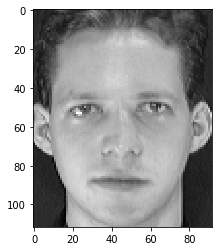

In [67]:
# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()

## 4. FIND W WHEN H0 IS FIXED
**Question 4.1** This choice is advantageous because all coefficients are positive and enable thus the problem to converge more quickly. We could have chosen randomly the initialization but the resolution would have taken more iterations. 

We choose $\sqrt(S)*W0$ and $\sqrt(S)*H_0$ because $M \approx W_0*S*H_0 \approx W_0\sqrt(S) * \sqrt(S)H_0$

In [68]:
n = 10
p = 112*92
W0, S, H0 = scipy.sparse.linalg.svds(M, k)
W0 = np.maximum(0, W0 * np.sqrt(S))
H0 = np.maximum(0,(H0.T * np.sqrt(S)).T)

L0 = np.linalg.norm(np.dot(H0.T, H0), ord = 'fro')/(n*p)


**Question 4.2** The objective  function is written as follows : $g(W)=\frac{1}{2np} ||M-WH_0||²_F  $. We derive this function of W : 
$\frac{d}{dW} ||M-WH_0||²_F = \frac{d}{dW} < M-WH_0, M-WH_0>$  <br>

$\Leftrightarrow \frac{d}{dW} ||M-WH_0||²_F = < -H_0, M-WH_0 > + <M-WH_0, -H_0 >$    
<br>
$\Leftrightarrow \frac{d}{dW} ||M-WH_0||²_F = 2*(WH_0 - M) H_0^T$
<br>
The second derivative of the objective function is : 
$\frac{d^2}{dW^2} ||M-WH_0||²_F = 2*H_0*H_0^T = 2 ||H_0||² > 0$
<br> The second derivative is nonnegative, thus the objective function is convex. 

**Question 4.3** The functions computing $g(W)$ and $\nabla g(W)$ are the following : 

In [69]:
#WWe compute g
def val_g(W):
    return np.sum((M-np.dot(W,H0))**2)/(2*n*p)


#We compute  the gradient of g
def grad_g(W):
    return np.dot(np.dot(W,H0) - M, np.transpose(H0))/(n*p)

#We check the correctness of the gradient 
def val_test(W):
    W = W.reshape((n,k))
    return val_g(W).ravel()

def grad_test(W):
    W = W.reshape((n,k))
    return grad_g(W).ravel()


scipy.optimize.check_grad(val_test,grad_test,W0.ravel())

1.244037315292823e-05

The value is very small so the computation is proper. 
<br>
<br>
<br>
**Question 4.4** We want to show that the proximal is the projection onto R+. 
<br> 
We have that : $ prox_{\gamma l \mathbf{R}^{+}} = argmin_{x \in \mathbf{R}} [ l(x) + \frac{1}{2} ||x-\gamma||^2]$
<br> 
The function $ x : \rightarrow l(x) + \frac{1}{2} ||x-\gamma||^2$ is minimal if $ l(x) = 0$, thus if $x \ge 0$.  <br>

$x \ge 0 \Rightarrow l(x) + \frac{1}{2} ||x-\gamma||^2 = \frac{1}{2} ||\gamma||^2 \ge 0$

<br> Thus : $ prox_{\gamma l \mathbf{R}^{+}} = \mathbf{R}^{+}$

**Question 4.5** We code the function below : 

In [70]:
def projected_gradient_method(val_g, grad_g, W0, gamma, N) :
    for i in range(N) :
        W0 = W0 - gamma*grad_g(W0)
        W0 = W0 * (W0>=0)
    return W0        

**Question 4.6** 

In [71]:
print(val_g(W0))
#print(val_g(projected_gradient_method(val_g, grad_g, W0, 1/L0, 100)))

438.81211268638407


In [72]:
# Full data
#M = build_matrix_from_faces(folder='orl_faces', minidata=False)
#def unvectorize(W_H): return unvectorize_M(W_H, M)
#k = 38

## 5. Algorithmic refinement for the problem with H0 fixed

**Question 5.1** We choose $ \gamma $ adaptively using local information. Knowing that the gradient of g is Lipschitz continuous and that we have a a closed formula for the 1-dimensionnal optimization problem, we implement the exact line search. We implement the line search bellow : 

In [73]:
def exact_line_search_projected_gradient_method(val_g, grad_g, W0, N):
    gamma_k = 0
    for i in range(N):
        nabla_g = grad_g(W0)
        diff = W0 - gamma*nabla_g
        f = lambda gamma: np.sum(-1 * nabla_g * grad_g(diff))
        gamma_opt = scipy.optimize.newton(f,gamma_k)
        W0 = W0 - gamma_opt * nabla_g
        W0 = W0 * (W0>=0)
    return W0

In [74]:
print(np.shape(W0))
#exact_line_search_projected_gradient_method(val_g, grad_g, W0, 100)

(10, 2)


In [75]:
print(np.shape(M))

(10, 10304)


## 6. Resolution of the full problem

**Question 6.1** We solve the problem by the projected gradient method. 

In [76]:
def val_g(W, H = H0):
    return np.sum((M-np.dot(W,H))**2)/(2*n*p)

def gradW_g(W, H):
    return np.dot(np.dot(W,H) - M,H.T)/(n*p) 

def gradH_g(W,H):
    return np.dot(W.T, np.dot(W,H) - M)/(n*p)

def line_search_projected_gradient_method_all(val_g, grad_g, W0, H0, N, gamma_prior = 0):
    def f(gamma):
        s = np.sum(-1 * nablaW * gradW_g(W0 - gamma * nablaW, H0 - gamma * nablaH))
        s += np.sum(-1 * nablaH * gradH_g(W0 - gamma * nablaW, H0 - gamma * nablaH))
        return s
    
    for i in range(N):
        nablaW = gradW_g(W0, H0)
        nablaH = gradH_g(W0, H0)
        gamma_opt = scipy.optimize.newton(f,gamma_prior)
        W0 = W0 - gamma_opt * nablaW
        W0 = W0 * (W0>=0)
        H0 = H0 - gamma_opt * nablaH
        H0 = H0 * (H0>=0)
    return W0, H0



In [77]:
W1, H1 = line_search_projected_gradient_method_all(val_g, grad_g, W0, H0, 1000)

In [78]:
val_g(W1,H1)

358.97282099488194

**Question 6.2** We implement the alternate minimization method : 

In [79]:
def alternate_method(W, H, N):
    def projected_gradient_method_W(W, H, gamma, N):
        for i in range(N):
            W = W - gamma * gradW_g(W,H)
            W = W * (W>=0)
        return W

    def projected_gradient_method_H(W, H, gamma, N):
        for i in range(N):
            H = H - gamma * gradH_g(W,H)
            H = H * (H>=0)
        return H

    i = 0
    while i<N:
        L = np.linalg.norm(np.dot(H.T, H), ord='fro')/(n*p)
        W = projected_gradient_method_W(W, H, 1/L, 100)
        L = np.linalg.norm(np.dot(W.T, W), ord='fro')/(n*p)
        H = projected_gradient_method_H(W, H, 1/L, 100)
        i+=1
    return W, H

In [ ]:
W1, H1 = alternate_method(W0, H0, 10)

In [ ]:
val_g(W1, H1)